In [285]:
# Articles
# - https://jyx.jyu.fi/handle/123456789/78083

In [286]:
# Notes

# Important paper  => Kania2021_Chapter_InteractiveMultiobjectiveOptim.pdf

In [287]:
# 
"""
Toimitusaika = 12kk
Tilauskustannus = 100 + 100

Ketjutettutilaus eteenpäin


Liquid zone -> 
Frozen zone -> määritelty materiaali tulee, oli tilattu tai ei

Vuoden jaksotettut tilaukset -> Milloin tilataan ja paljon
"""

'\nToimitusaika = 12kk\nTilauskustannus = 100 + 100\n\nKetjutettutilaus eteenpäin\n\n\nLiquid zone -> \nFrozen zone -> määritelty materiaali tulee, oli tilattu tai ei\n\nVuoden jaksotettut tilaukset -> Milloin tilataan ja paljon\n'

In [288]:
import pandas as pd
import numpy as np

df = pd.read_excel('Demand_data_case.xlsx')

months = []
# month = 1
# for i in range(1, 109):
#     if month % 13 == 0:
#         month = 1
#     months.append(month)
#    month = month + 1
df['months'] = list(range(1,109))
df

print(df)

     Month  Demand (pcs)  months
0    m_001            11       1
1    m_002            12       2
2    m_003            10       3
3    m_004             8       4
4    m_005            12       5
..     ...           ...     ...
103  m_104             3     104
104  m_105             0     105
105  m_106             0     106
106  m_107             3     107
107  m_108             5     108

[108 rows x 3 columns]


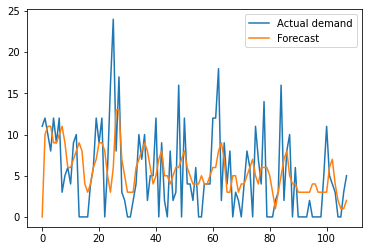

In [289]:
# Sales forcecast
"""
ARIMA
"""

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

model = ARIMA(df['Demand (pcs)'], order=(5,1,1))
model_fit = model.fit()
#print(model_fit.summary())

# Actual vs Fitted
forecast = model_fit.predict().astype(int)
plt.plot(df['Demand (pcs)'], label="Actual demand")
plt.plot(forecast, label="Forecast")
plt.legend()
plt.show()


In [290]:
x1 = np.array(df['Demand (pcs)'])  # Demand
x2 = np.array(df['months'])        # Months / timeline
x3 = np.array(df['Demand (pcs)'])  # Orders

x = pd.array([forecast, x2, x3])

In [291]:
# Objectives
"""
f1 -> Availability / No stock out -> service level / fill rate
    Maximize
    Total Number of Customer Orders Shipped / Number of Customer Orders Filled

f2 -> Holding cost
    Minimize

    Q = Optimal order quantity
    H = Holding cost per unit => Fixed 10% of unit price
    Q/2 x H
f3 -> Inventory turnover rate # Not part of this project
"""


def f1(x):
    return x[2] / x[0]

def f2(x):
    return (x[0] / 2) * 6500*0.1

f_1 = f1(x)
f_2 = f2(x)

f_1[f_1 == np.inf] = 0

print(f_1)
print(f_2)


0      0.000000
1      1.200000
2      0.909091
3      0.727273
4      1.333333
         ...   
103    0.750000
104    0.000000
105    0.000000
106    3.000000
107    2.500000
Name: predicted_mean, Length: 108, dtype: float64
0         0.0
1      3250.0
2      3575.0
3      3575.0
4      2925.0
        ...  
103    1300.0
104     650.0
105     325.0
106     325.0
107     650.0
Name: predicted_mean, Length: 108, dtype: float64


In [292]:
# Constraits
"""
c1 -> Stock greater than zero
c2 -> Max stock amount
"""
from desdeo_problem import ScalarConstraint

def const_func_1(x, y):
    ret = []
    for yi in y:
        ret.append(1 - yi[0])
    return np.array(ret)

c1 = ScalarConstraint('c_1', 3, 2, const_func_1)

def const_func_2(x, y):
    ret = []
    for yi in y:
        ret.append(2000 - yi[1])
    return np.array(ret)

c2 = ScalarConstraint('c_2', 3, 2, const_func_2)

In [293]:

# Safety stock

R = np.mean(x[0])
std_R = np.std(x[0])
L = 12 # lead time - 12 months
#sL = 0 # lead time standard deviation
CSL = 0.9 # cycle service level

SS = (CSL * std_R * L)**0.5
print('safety stock', SS)

print('Demand mean / average', R)
print('Demand standard deviation', std_R)

safety stock 5.24463355474165
Demand mean / average 5.564814814814815
Demand standard deviation 2.546868622548337


In [294]:
# Surrogate
from desdeo_problem import VectorDataObjective as VDO
from desdeo_problem.surrogatemodels.SurrogateModels import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

#data = np.hstack((x, f_1, f_2))
#print(data)

data = {
    'x1': x[0],  # demand / forecast
    'x2': x[1],  # months
    'x3': x[2],  # orders
    'f1': f_1, 
    'f2': f_2
}

datapd = pd.DataFrame(data=data) # columns=['x1', 'x2', 'f1', 'f2']

print(datapd)
obj = VDO(data=datapd, name=['f1', 'f2'])

obj.train(models=GaussianProcessRegressor, model_parameters={'kernel': Matern(nu=1.5)})
 
print(obj.evaluate(np.asarray([[3,2, 4]]), use_surrogate=True))

     x1   x2  x3        f1      f2
0     0    1  11  0.000000     0.0
1    10    2  12  1.200000  3250.0
2    11    3  10  0.909091  3575.0
3    11    4   8  0.727273  3575.0
4     9    5  12  1.333333  2925.0
..   ..  ...  ..       ...     ...
103   4  104   3  0.750000  1300.0
104   2  105   0  0.000000   650.0
105   1  106   0  0.000000   325.0
106   1  107   3  3.000000   325.0
107   2  108   5  2.500000   650.0

[108 rows x 5 columns]
Objective Evaluation Results Object 
Objective values are: 
       f1           f2
0  0.2109  1013.313435
Uncertainity values are: 
         f1        f2
0  0.718193  0.648254



/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


In [295]:
# Problem

from desdeo_problem import DataProblem

maximize = pd.DataFrame([[True, True]], columns=['f1','f2'])
prob = DataProblem(data=datapd, objective_names=['f1','f2'], variable_names=['x1', 'x2', 'x3'], constraints=[c1, c2], maximize=maximize)

prob.train(GaussianProcessRegressor)

data_to_evaluate = []
for i in range(len(x[0])):
    data_to_evaluate.append([x[0][i], x[1][i], x[2][i]])

result = prob.evaluate(np.asarray(data_to_evaluate), use_surrogate=True)

print(result)

Evaluation Results Object 
Objective values are: 
[[ 7.26369815e-32  1.60033367e-28]
 [ 1.20000000e+00  3.25000000e+03]
 [ 9.09090909e-01  3.57500000e+03]
 [ 7.27272727e-01  3.57500000e+03]
 [ 1.33333333e+00  2.92500000e+03]
 [ 1.00000000e+00  2.92500000e+03]
 [ 1.20000000e+00  3.25000000e+03]
 [ 2.72727273e-01  3.57500000e+03]
 [ 5.55555556e-01  2.92500000e+03]
 [ 1.00000000e+00  1.95000000e+03]
 [ 6.66666667e-01  1.95000000e+03]
 [ 1.28571429e+00  2.27500000e+03]
 [ 1.25000000e+00  2.60000000e+03]
 [ 2.38717376e-18  2.92500000e+03]
 [ 1.35349909e-19  2.60000000e+03]
 [ 0.00000000e+00  1.30000000e+03]
 [ 1.22054060e-14  9.75000000e+02]
 [ 1.00000000e+00  1.30000000e+03]
 [ 1.00000000e+00  1.95000000e+03]
 [ 1.71428571e+00  2.27500000e+03]
 [ 1.00000000e+00  2.92500000e+03]
 [ 1.33333333e+00  2.92500000e+03]
 [ 1.66299751e-20  2.60000000e+03]
 [ 1.20000000e+00  1.62500000e+03]
 [ 5.33333333e+00  9.75000000e+02]
 [ 4.00000000e+00  1.95000000e+03]
 [ 6.15384615e-01  4.22500000e+03]
 [ 1.

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


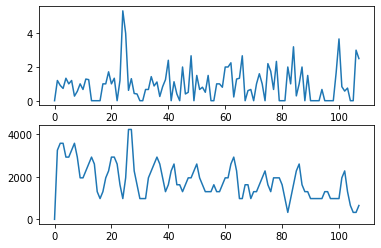

In [296]:
f1 = []
f2 = []

for i in result[0]:
    f1.append(i[0])
    f2.append(i[1])

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(f1)

ax2.plot(f2)